In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras import layers, models, callbacks, optimizers
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error,r2_score
import math

In [9]:
path = '/Users/HP Spectre/OneDrive - student.kit.edu/uni/Master/Lissabon Kurse/Intelligent Systems/IntSysGroup6/'

data = pd.read_csv(path+'Project/data/robot_inverse_kinematics_dataset_own.csv')
q3_pred= pd.read_csv(path+"Project/saved_pred/q3_pred_own.csv")
#data = pd.concat([data,q3_pred],axis=1)
X = data.iloc[:, 6:]
y = data.iloc[:, 0:5]

y = y.drop(['q3',],axis=1) #removing column 3 '''

X = pd.concat([X,q3_pred],axis=1)
scaler_X = MinMaxScaler()
scalers = [MinMaxScaler() for _ in range(5)]

for i,column in enumerate(y.columns):
    y[[column]] = scalers[i].fit_transform(y[[column]])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.2)

In [11]:
def create_model():
    model = tf.keras.Sequential([
        layers.Input(shape=(4,)),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(100, activation='relu'),
        layers.Dense(1)
    ])
    return model

In [12]:
histories = []
mae_scores = []
r2_scores = []

for i, column in enumerate(y.columns):
    print(f"Training model for {column}")
    model = create_model()
    model.compile(
        loss='mean_squared_error',
        optimizer=optimizers.Adam(learning_rate=0.001, weight_decay=0.01)
    )
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True
    )
    history = model.fit(
        X_train,
        y_train[column],
        validation_split=0.2,
        verbose=1,
        epochs=50,
        callbacks=[early_stopping]
    )
    histories.append(history)
    
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test[column], y_pred)

    
    # Inverse scaling to get MAE in degrees
    y_pred_inverse = scalers[i].inverse_transform(y_pred)
    y_test_inverse = scalers[i].inverse_transform(y_test[[column]])
    mae_degrees = mean_absolute_error(y_test_inverse, y_pred_inverse)
    
    r2 = r2_score(y_test_inverse, y_pred_inverse)
    mae_scores.append(mae_degrees)
    r2_scores.append(r2)

    print(f"MAE for {column}: {mae_degrees} degrees")
    print(f"R-squared (R2) Score for {column}: {r2}")

Training model for q1


Epoch 1/50
100/100 [==============================] - 2s 5ms/step - loss: 0.5684 - val_loss: 0.0753
Epoch 2/50
100/100 [==============================] - 0s 3ms/step - loss: 0.1422 - val_loss: 0.0719
Epoch 3/50
100/100 [==============================] - 0s 3ms/step - loss: 0.1041 - val_loss: 0.0664
Epoch 4/50
100/100 [==============================] - 0s 3ms/step - loss: 0.0886 - val_loss: 0.0771
Epoch 5/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0849 - val_loss: 0.0706
Epoch 6/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0751 - val_loss: 0.0644
Epoch 7/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0714 - val_loss: 0.0589
Epoch 8/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0704 - val_loss: 0.0704
Epoch 9/50
100/100 [==============================] - 0s 5ms/step - loss: 0.0662 - val_loss: 0.0580
Epoch 10/50
100/100 [==============================] - 1s 6ms/step - loss: 0.0648 - val_loss: 0.0589

In [13]:
for i, column in enumerate(y.columns):
    print(f"MAE for {column}: {math.degrees(mae_scores[i])} degrees")
    print(f"R-squared (R2) Score for {column}: {r2_scores[i]*100}")

MAE for q1: 16.78841961615469 degrees
R-squared (R2) Score for q1: 36.18747047158249
MAE for q2: 13.759195321721945 degrees
R-squared (R2) Score for q2: 56.66563292653335
MAE for q4: 17.41579160292008 degrees
R-squared (R2) Score for q4: 26.879599395091148
MAE for q5: 16.67033504768723 degrees
R-squared (R2) Score for q5: 37.02212373200244


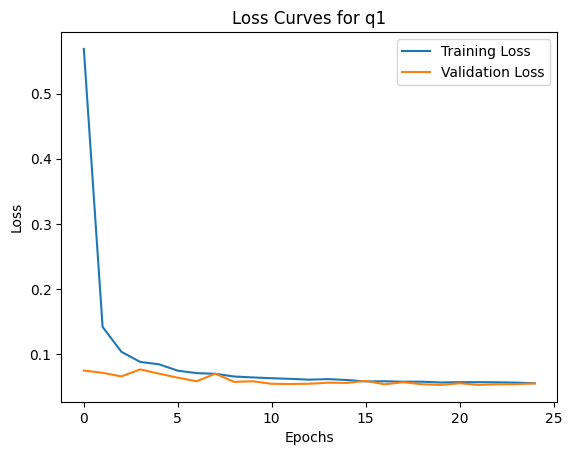

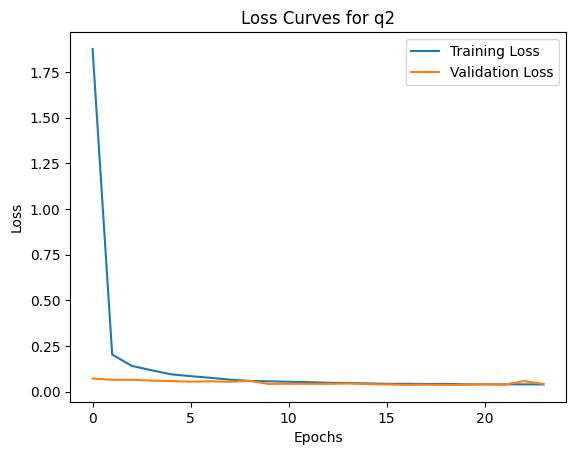

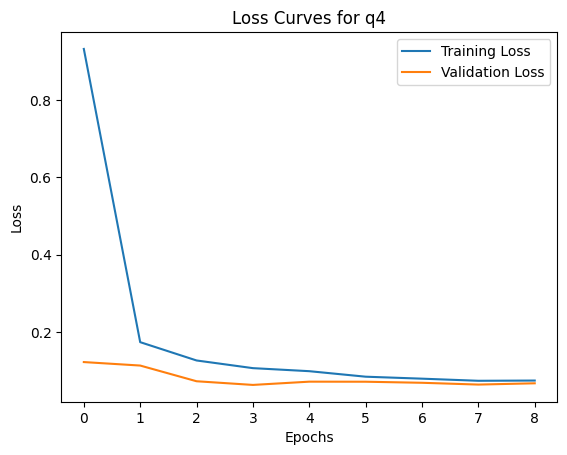

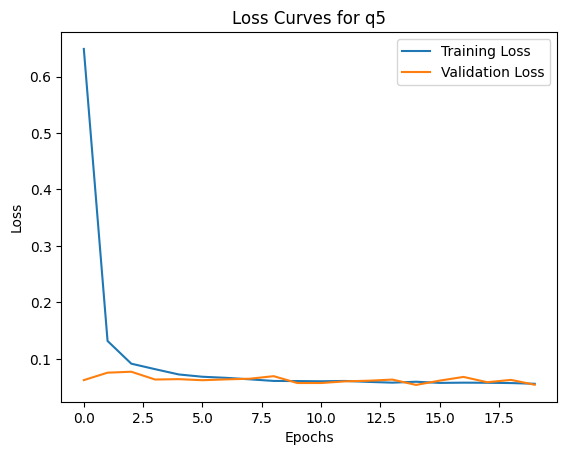

In [14]:
# Plot the loss curves for all models
import matplotlib.pyplot as plt

for i, history in enumerate(histories):
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves for {y.columns[i]}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plt.show()